In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.4.0-rc0


---
### 1. VGG output

In [3]:
# load the VGG16 model, this time - with the "top" (its fully-connected layers)

vgg16 = tf.keras.applications.VGG16(input_shape=(224,224,3),
                                               include_top=True,
                                               weights='imagenet')

vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

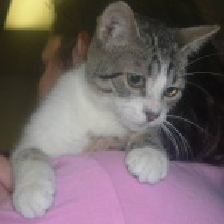

In [11]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

image = load_img('cat016.jpg', target_size=(224, 224)) # load image in PIL format
image

In [12]:
img = img_to_array(image)  # convcert to NumPy (224,224,3)
img = img[None] # expand dimensions: (224,224,3) - >(1,224,224,3)

In [13]:
# preprocess the image, in the same way all images were processed during training:
from tensorflow.keras.applications.vgg16 import preprocess_input 
img = preprocess_input(img)
print('img.shape =',img.shape)

img.shape = (1, 224, 224, 3)


In [34]:
# activations of the last layer (model's output):

yhat = vgg16.predict(img) 
yhat.shape

(1, 1000)

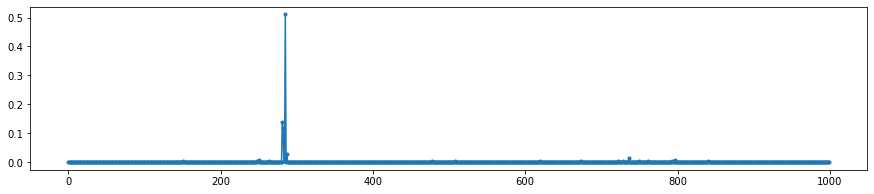

In [35]:
plt.figure(figsize=(15,3))
plt.plot(yhat[0],'.-')

In [21]:
# decode predictions:
from tensorflow.keras.applications.vgg16 import decode_predictions 
decode_predictions(yhat)

[[('n02124075', 'Egyptian_cat', 0.51168436),
  ('n02123045', 'tabby', 0.13776208),
  ('n02123159', 'tiger_cat', 0.11915372),
  ('n02127052', 'lynx', 0.027568718),
  ('n03982430', 'pool_table', 0.013903784)]]

---
### 2. Activation maps

In [24]:
for i,l in enumerate(vgg16.layers):
    print(i,'\t',l.output_shape[1:],'\t\t',l.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 flatten
20 fc1
21 fc2
22 predictions


In [29]:
vgg16.layers[13].name

'block4_conv3'

In [44]:
vgg16.layers[13].output_shape

(None, 28, 28, 512)

In [33]:
# define a new model for extracting the activation map,
# using the Functional API:

activations = keras.Model(inputs=vgg16.inputs, outputs=vgg16.layers[13].output)
activations.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [37]:
yhat = vgg16.predict(img)  # the full VGG model (end-to-end)

a = activations.predict(img) # the truncated VGG model 

print('yhat.shape = ',yhat.shape)

print('a.shape = ',a.shape)

yhat.shape =  (1, 1000)
a.shape =  (1, 28, 28, 512)


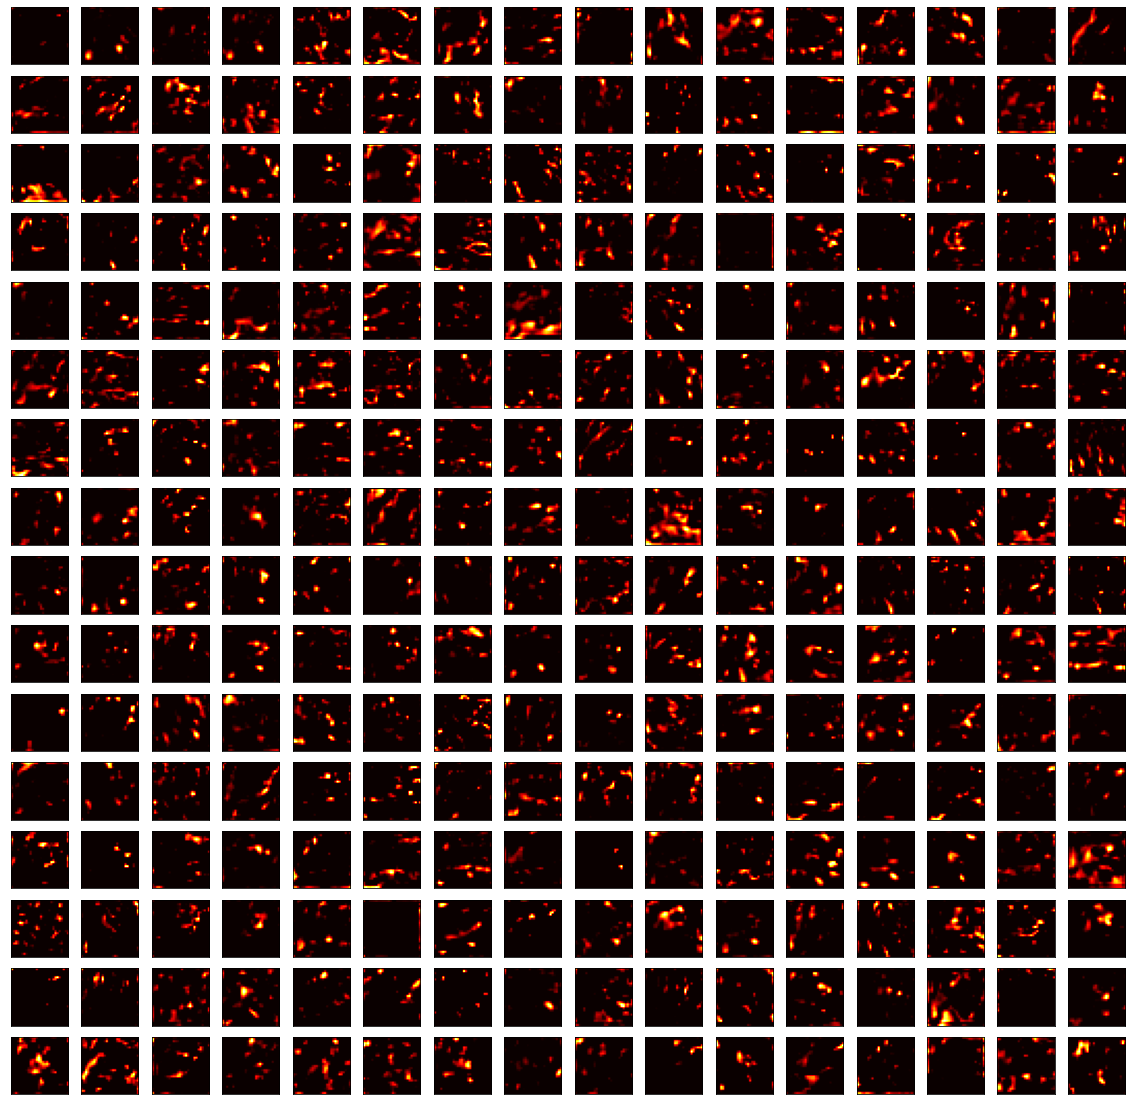

In [39]:
plt.figure(figsize=(20,20))
for i in range(256):
    plt.subplot(16,16,i+1)
    plt.imshow(a[0,:,:,i], cmap='hot')
    plt.xticks([])
    plt.yticks([])

---
### 3. Features extractions

In [40]:
# let's pick the last layer *before* the output
vgg16.layers[-2].name

'fc2'

In [43]:
vgg16.layers[-2].output_shape

(None, 4096)

In [45]:
# define a new model, to extract the activation of this layer:

features_extractor = keras.Model(inputs=vgg16.inputs, outputs=vgg16.layers[-2].output)

features_4096D = features_extractor.predict(img)

features_4096D.shape

(1, 4096)

In [49]:
# let's do that for 60 images of cats and dogs:


from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataGen = ImageDataGenerator(preprocessing_function=preprocess_input) # tf.keras.applications.vgg16.preprocess_input

testGen = dataGen.flow_from_directory('catsvsdogs/small', target_size=(224,224), batch_size=60, shuffle=False)

Found 60 images belonging to 2 classes.


In [59]:
y = testGen.classes
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [54]:
features_4096D = features_extractor.predict(testGen)
features_4096D.shape

(60, 4096)

In [71]:
# let's use PCA to project 4096-D to 2-D:
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(features)

features_2D = pca.transform(features_4096D)
features_2D.shape

(60, 2)

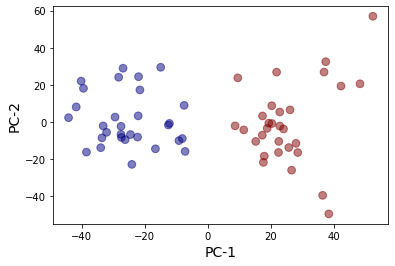

In [72]:
plt.scatter(features_2D[:,0], features_2D[:,1], s=60, c=y, 
            cmap='jet', alpha=0.5)

plt.xlabel('PC-1',fontsize=14)
plt.ylabel('PC-2',fontsize=14)
plt.show()

In [73]:
# we can also use t-SNE (instead of PCA) for dimensionality reduction:
# https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

from sklearn.manifold import TSNE

features_2D = TSNE(n_components=2).fit_transform(features_4096D)
features_2D.shape

(60, 2)

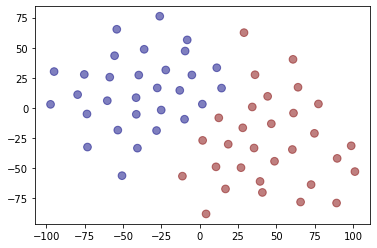

In [78]:
plt.scatter(features_2D[:,0], features_2D[:,1], s=60, c=y, 
            cmap='jet', alpha=0.5)


plt.show()

In [75]:
# now, let's try to do that in the image (pixels) space:

x_batch, y_batch = testGen.next()
print('x_batch.shape = ',x_batch.shape)
print('y_batch.shape = ',y_batch.shape)

x_batch.shape =  (60, 224, 224, 3)
y_batch.shape =  (60, 2)


In [77]:
X = x_batch.reshape(60,-1)
X.shape

(60, 150528)

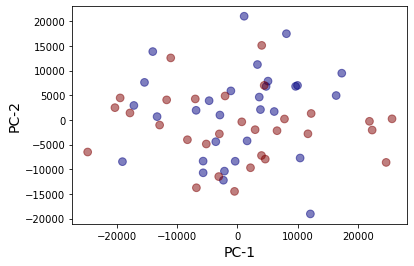

In [81]:
pca = PCA(n_components=2).fit(X)

features_2D = pca.transform(X)

plt.scatter(features_2D[:,0], features_2D[:,1], s=60, c=y, 
            cmap='jet', alpha=0.5)

plt.xlabel('PC-1',fontsize=14)
plt.ylabel('PC-2',fontsize=14)
plt.show()

---
### 4. Maximally activating patches

In [83]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_test.shape =  (10000, 32, 32, 3)
y_test.shape =  (10000, 1)


In [85]:
model = tf.keras.models.load_model('cifar_model') # pretrained VGG-like model

# all Conv2D layers uses 3x3 kernels, with padding='same'

for i,l in enumerate(model.layers):
    print(i,l.name)

0 conv2d
1 batch_normalization
2 conv2d_1
3 batch_normalization_1
4 max_pooling2d
5 dropout
6 conv2d_2
7 batch_normalization_2
8 conv2d_3
9 batch_normalization_3
10 max_pooling2d_1
11 dropout_1
12 conv2d_4
13 batch_normalization_4
14 conv2d_5
15 batch_normalization_5
16 max_pooling2d_2
17 dropout_2
18 flatten
19 dense


In [87]:
# let's pick the 2nd conv layer:

activations_extractor = Model(inputs = model.input, outputs = model.layers[2].output)

activations = activations_extractor.predict(x_test)
activations.shape # (samples, H, W, Ch.)

(10000, 32, 32, 32)

In [88]:
# pick one of the 32 filters
filter_id = 4

# find the strongest activation (over all samples and spatial locations):
idx = np.argmax(activations[:,:,:,filter_id])

idx

5205517

In [91]:
(img_idx, i, j) = np.unravel_index(idx, activations.shape[:3])

(img_idx, i, j)

(5083, 16, 13)

In [93]:
# now, we need to crop the right patch from that image:

img = x_test[img_idx]
img.shape


(32, 32, 3)

In [94]:
img_padded = np.pad(img,((2,2),(2,2),(0,0)))
img_padded.shape


(36, 36, 3)

In [100]:
patch = img_padded[i:i+5, j:j+5, :] # see slides from class...
patch.shape

(5, 5, 3)

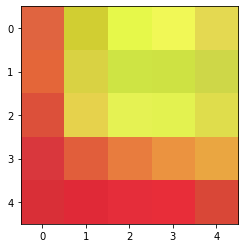

In [99]:
plt.imshow(patch);